# K-means

## Небольшое отступление
Привет!
У меня всё никак не получается вернуться к последовательному рассказу про язык Python с нуля, поэтому я решил переключиться на другие темы.
Я понимаю, что это слегка не честно.
Однако, если я не переключусь на что-то другое, то канал так и будет простаивать.
Поэтому попробуем посмотреть на различные применения языка Python.


## Настройка окружения

В данном эпизоде мы с нуля рассмотрим процесс написания простенькой реализации метода кластеризации k-средних (он же k-means).
Я буду предполагать, что тебе известно про пакеты в языке Python, а также известно про виртуальные окружения.
Давай создадим отдельную папку для нашего сегодняшнего ролика.
Я назову её `naive_kmeans`.
Теперь я создам виртуальное окружение внутри этой папки, следующим образом:
```bash
python -m venv ./venv_utils
```
После этого нам необходимо активировать виртуальное окружение:
```bash
source venv_utils/bin/activate
```
В случае windows необходимо выполнить следующуй команду:
```powershell
venv_utils\Scripts\activate.bat
```

Отлично.
Виртуальное окружение активировано и мы можем перейти к процессу установки необходимых библиотек.
```bash
pip install numpy pandas plotnine scikit-learn
```
<!-- pip install jupyterlab -->

## Генерация данных

Теперь непосредственно перейдем к нашей задаче.
Я содам файл с названием `k_means.py`.
Для начала подключим все необходимые нам библиотеки.

In [10]:
import numpy as np
import plotnine as gg
import pandas as pd

from sklearn.datasets import make_blobs

После этого сгенерируем наши точки, которые мы хотим закластеризовать:

In [11]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42)
X = (X - X.mean(axis=0)) / X.std(axis=0)

X = pd.DataFrame(X, columns=("x1", "x2"))

Наши данные, представляют собой таблицу с координатами точек:

In [12]:
print(X.head())

         x1        x2
0 -1.257301 -1.524866
1  1.499872 -0.113177
2 -0.264088  1.248653
3  1.623146 -0.139594
4 -1.005307 -1.204185


Теперь давай просто нарисуем то, как выглядят наши исходные данные:

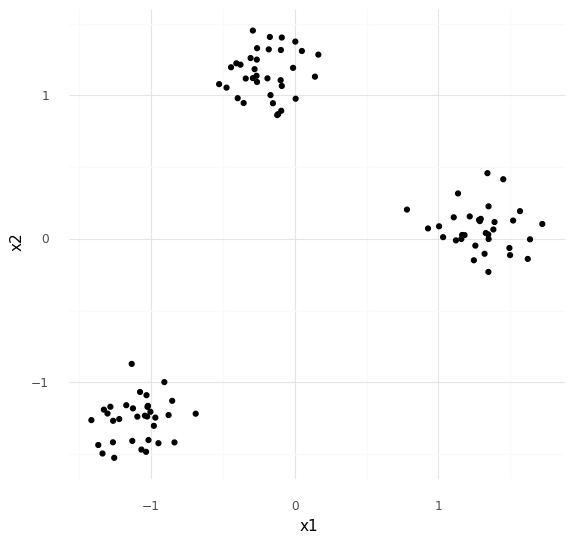

<ggplot: (8726741487815)>

In [13]:
ggplt = (
    gg.ggplot(data=X, mapping=gg.aes(x="x1", y="x2")) + 
    gg.geom_point() + 
    gg.coord_fixed() + 
    gg.theme_minimal()
)

ggplt
# В обычно .py файле необходимо использовать следующее выражение:
# ggplt.draw(show=True) 

Запустим нашу программу и убедимся, что всё корректно работает:
```bash
python k_means.py
```

Давай заведем новый столбец в нашей таблице, в котором мы будем хранить номер кластера, которому принадлежит точка.
Для начала просто присвоим всем точкам кластер нуля.
Далее мы будем пересчитывать номер кластера для каждой точки.

In [106]:
X["cluster"] = "0"
print(X.head())

         x1        x2 cluster
0 -1.257301 -1.524866       0
1  1.499872 -0.113177       0
2 -0.264088  1.248653       0
3  1.623146 -0.139594       0
4 -1.005307 -1.204185       0


Нам остается только воплатить в жизнь ту визуализацию, что мы видели вначале.
Итак, нам нужно выбрать три случайные точки среди всех.
Заведем функцию, которая возвращает три случайных индекса.
В качестве аргументов, пусть она принимает число точек и число кластеров:

In [107]:
def get_rand_indxs(n, k):
    return(np.random.randint(0, n, size=k))

Вычислим текущие положения центров:

In [108]:
np.random.seed(42) # Зафиксируем генератор случайных чисел, для воспроизводимости результатов
rindxs = get_rand_indxs(X.shape[0], 3)
centers = X.iloc[rindxs, 0:2]

X.iloc[rindxs, 2] = ["1", "2", "3"]

Нарисуем наши текущие данные:

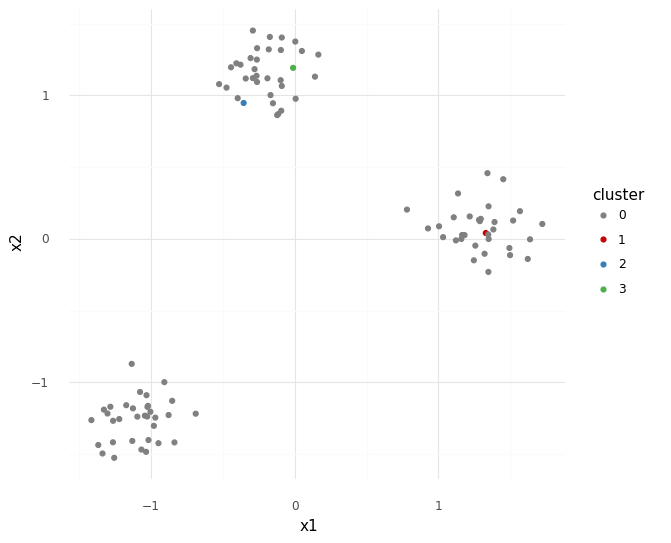

<ggplot: (8726728972811)>

In [109]:
ggplt = (
    gg.ggplot(data=X, mapping=gg.aes(x="x1", y="x2", color="cluster")) + 
    gg.geom_point() + 
    gg.coord_fixed() + 
    gg.theme_minimal() + 
    gg.scale_color_manual(values=["gray", "#c20305", "#377eb8", "#4daf4a"])
)

ggplt
# В обычно .py файле необходимо использовать следующее выражение:
# ggplt.draw(show=True) 

In [110]:
((X.iloc[rindxs, 0:2] - X.iloc[0, 0:2]) ** 2).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

51    3.024762
92    2.630768
14    2.988289
dtype: float64

Заведем функцию, которая будет для каждой точки находить ближайший к ней центр кластера.
Здесь я буду использовать довольно кривой цикл по числу точек в нашей таблице.
По-хорошему, здесь нужно пользоваться свойствами dataframe-ов.
Данная функция создает пустой список, в который мы будет помещать метку кластера.
Затем для каждой точки из таблицы вычисляются расстояния до текущих центров.
После этого мы определяем индекс минимального элемента и используем этот индекс для выбора метки из `["1", "2", "3"]`.

In [111]:
def get_clusters(coords, centers):
    result = []
    for i in range(coords.shape[0]):
        distances = (centers - coords.iloc[i]) ** 2
        distances = distances.apply(lambda x: np.sqrt(np.sum(x)), axis=1)
        result.append(["1", "2", "3"][distances.argmin()])
    return result

Воспользуемся функцией и обновим метки кластеров в нашем dataframe-е.

In [112]:
clusters = get_clusters(X.iloc[:, 0:2], centers)
X.cluster = clusters

Нарисуем обновленный вариант картинки с нашими данными:

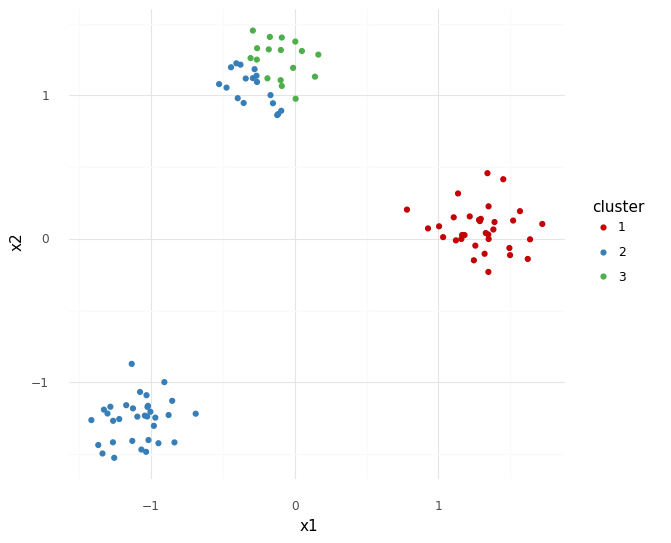

<ggplot: (8726728997045)>

In [113]:
ggplt = (
    gg.ggplot(data=X, mapping=gg.aes(x="x1", y="x2", color="cluster")) + 
    gg.geom_point() + 
    gg.coord_fixed() + 
    gg.theme_minimal() + 
    gg.scale_color_manual(values=["#c20305", "#377eb8", "#4daf4a"])
)

ggplt
# В обычно .py файле необходимо использовать следующее выражение:
# ggplt.draw(show=True) 

Далее, нам необходимо определить центры для полученных кластеров.
Для этого заведем дополнительную функцию, которая на вход примает наш dataframe и для каждого кластера вычисляет его центр:

In [114]:
def get_centers(X):
    return X.groupby("cluster").mean().reset_index(drop=True)

centers = get_centers(X)

Теперь мы можем отобразить текущие центры:

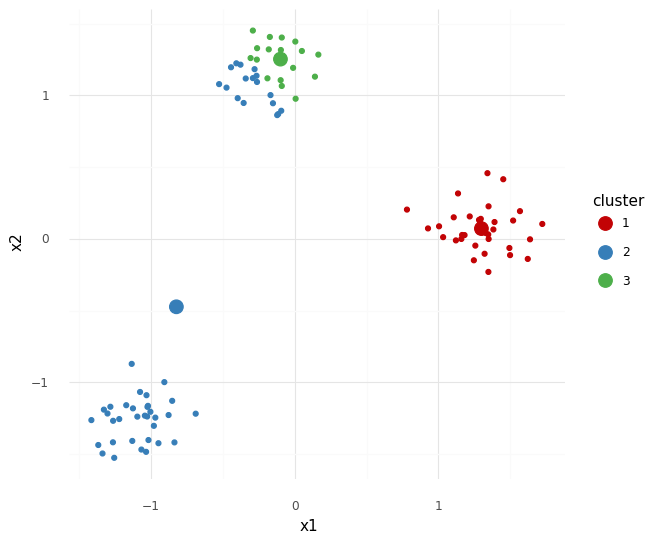

<ggplot: (8726728972619)>

In [115]:
centers_for_plot = pd.concat((centers, pd.DataFrame({"cluster": ["1", "2", "3"]})), axis=1)
ggplt = (
    gg.ggplot(data=X, mapping=gg.aes(x="x1", y="x2", color="cluster")) + 
    gg.geom_point() + 
    gg.coord_fixed() + 
    gg.theme_minimal() + 
    gg.geom_point(data=centers_for_plot, mapping=gg.aes(x="x1", y="x2"), size=5) + 
    gg.scale_color_manual(values=["#c20305", "#377eb8", "#4daf4a"])
)

ggplt
# В обычно .py файле необходимо использовать следующее выражение:
# ggplt.draw(show=True)

Нам осталось лишь повторять вышеприведенные шаги до тех пор, пока лейблы кластеров не совпадут для двух последовательных итераций.
Оформим это в виде цикла `while`:

In [116]:
while True:
    old_clusters = X.cluster
    X.cluster = get_clusters(X.iloc[:, 0:2], centers)
    if np.array_equal(X.cluster, old_clusters):
        break
    centers = get_centers(X)

В результате, мы получаем следующий результат:

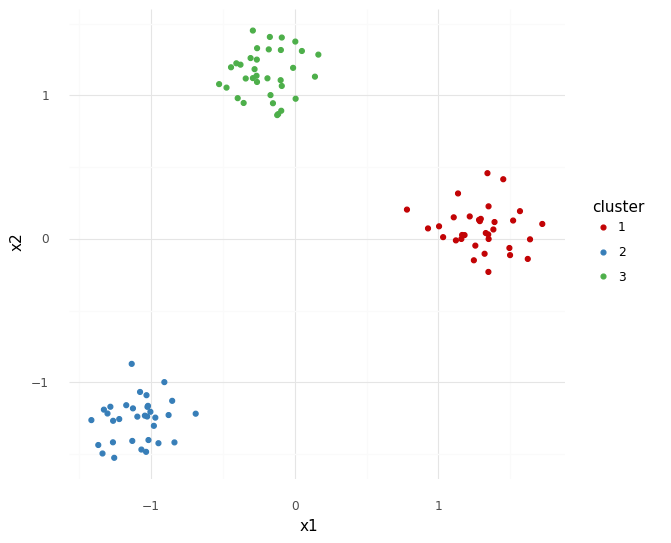

<ggplot: (8726729003795)>

In [117]:
ggplt = (
    gg.ggplot(data=X, mapping=gg.aes(x="x1", y="x2", color="cluster")) + 
    gg.geom_point() + 
    gg.coord_fixed() + 
    gg.theme_minimal() + 
    gg.scale_color_manual(values=["#c20305", "#377eb8", "#4daf4a"])
)

ggplt
# В обычно .py файле необходимо использовать следующее выражение:
# ggplt.draw(show=True) 

Я знаю, что какие-то куски могут быть не супер очевидными, но я всегда готов помочь разобраться в деталях.
Просто дай мне знать в комментариях, либо в телеграм-чате.
На этом на сегодня всё.
В следующий раз мы рассмотрим пример использования кластеризации для реальных данных, а не синтетичексих.
Я думаю, что набор случайных точек не сильно интригует, но попробуем рассмотреть что-нибудь повеселее.
До скорой встречи друг.